In [5]:
# from rocket_main import generate_kernelss, apply_kernels
from sklearn.linear_model import RidgeClassifierCV
import sys  
import numba
sys.path.insert(1, '../')
from pre_processing_clean import pre_processing
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.exceptions import DataConversionWarning
import asyncio
from xgboost import XGBClassifier
import pickle
from sklearn.feature_selection import SelectFdr, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from scipy.stats import sem




In [29]:
## ROCKET FUNCTIONS TO BE MODIFIED
from numba import njit, prange
# @njit("Tuple((float64[:],int32[:],float64[:],int32[:],int32[:]))(int64,int64)")
@njit("Tuple((float64[:],int32[:],float64[:],int32[:],int32[:]))(int64,int64,int32[:])")
def generate_kernelss(input_length, num_kernels,kernel_len):
    #7,9,11
    # candidate_lengths = np.array((20,20,20), dtype = np.int32)
    candidate_lengths=kernel_len
    lengths = np.random.choice(candidate_lengths, num_kernels)

    weights = np.zeros(lengths.sum(), dtype = np.float64)
    biases = np.zeros(num_kernels, dtype = np.float64)
    dilations = np.zeros(num_kernels, dtype = np.int32)
    paddings = np.zeros(num_kernels, dtype = np.int32)

    a1 = 0

    for i in range(num_kernels):

        _length = lengths[i]

        _weights = np.random.normal(0, 1, _length)

        b1 = a1 + _length
        weights[a1:b1] = _weights - _weights.mean()

        biases[i] = np.random.uniform(-1, 1)

        # dilation = 2 ** np.random.uniform(0, np.log2((input_length - 1) / (_length - 1))) if _length != input_length else 1
        dilation = 2 ** np.random.uniform(0, np.log2(max((input_length - 1) / (_length - 1), 1))) if _length != input_length else 1

        # dilation = 2 ** np.random.uniform(0, np.log2((input_length - 1) / (_length - 1)))
        dilation = np.int32(dilation)
        dilations[i] = dilation

        padding = ((_length - 1) * dilation) // 2 if np.random.randint(2) == 1 else 0
        paddings[i] = padding

        a1 = b1

    return weights, lengths, biases, dilations, paddings



@njit(fastmath = True)
def apply_kernel(X, weights, length, bias, dilation, padding):

    input_length = len(X)

    output_length = (input_length + (2 * padding)) - ((length - 1) * dilation)

    _ppv = 0
    # _max = np.NINF

    end = (input_length + padding) - ((length - 1) * dilation)

    for i in range(-padding, end):

        _sum = bias

        index = i

        for j in range(length):

            if index > -1 and index < input_length:

                _sum = _sum + weights[j] * X[index]

            index = index + dilation

        # if _sum > _max:
        #     _max = _sum

        if _sum > 0:
            _ppv += 1
# , _max
    return _ppv / output_length

@njit("float64[:,:](float64[:,:],Tuple((float64[::1],int32[:],float64[:],int32[:],int32[:])))", parallel = True, fastmath = True)
def apply_kernels(X, kernels):

    weights, lengths, biases, dilations, paddings = kernels

    num_examples, _ = X.shape
    num_kernels = len(lengths)

    _X = np.zeros((num_examples, num_kernels * 1), dtype = np.float64) # 2 features per kernel

    for i in prange(num_examples):

        a1 = 0 # for weights
        a2 = 0 # for features

        for j in range(num_kernels):

            b1 = a1 + lengths[j]
            b2 = a2 + 2

            _X[i, a2:b2] = \
            apply_kernel(X[i], weights[a1:b1], lengths[j], biases[j], dilations[j], paddings[j])

            a1 = b1
            a2 = b2

    return _X

# Normalize the data
def normalize_data(X):
    mean = X.mean(axis=-1, keepdims=True)
    std = X.std(axis=-1, keepdims=True) + 1e-8
    return (X - mean) / std



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
files = ["data/non_alc_curves.csv"] 
df2=pre_processing(files)

##### Original dataset: 60 observations per sec 
- d_30: 30 per sec (drop every other row)\\
- d_20: 20 per sec (drop every 3th row )
- d_10: 10 per sec (drop every 6th row )

In [5]:
def cut_timesteps(dataset, n):
    dataframe = dataset.copy()  
    for k in range(len(dataframe)):
        if k % 2 == 0:  
            data = dataframe[k]
            data_reshaped = data.reshape(data.shape[0], data.shape[1], -1, n)
            dataframe[k] = data_reshaped.mean(axis=-1)
        else:
            if len(dataframe[k].shape) == 1:  
                dataframe[k] = dataframe[k]
            else:
                dataframe[k] = dataframe[k]  
                

    data_reshaped_x_train = normalize_data(dataframe[0].reshape(dataframe[0].shape[0], -1))
    data_reshaped_y_train = dataframe[1].reshape(dataframe[1].shape[0], -1)
    data_reshaped_x_test = normalize_data(dataframe[2].reshape(dataframe[2].shape[0], -1))
    data_reshaped_y_test = dataframe[3].reshape(dataframe[3].shape[0], -1)
    
    dataframe[0] = data_reshaped_x_train
    dataframe[1] = data_reshaped_y_train
    dataframe[2] = data_reshaped_x_test
    dataframe[3] = data_reshaped_y_test
    
    return dataframe

In [38]:
df_60=cut_timesteps(df2,1)
df_30=cut_timesteps(df2,2)
df_20=cut_timesteps(df2,3)
df_10=cut_timesteps(df2,6)


with open("df_60.pkl", "wb") as f:
    pickle.dump(df_60, f)

with open("df_30.pkl", "wb") as f:
    pickle.dump(df_30, f)

with open("df_20.pkl", "wb") as f:
    pickle.dump(df_20, f)
with open("df_10.pkl", "wb") as f:
    pickle.dump(df_10, f)
#all normalized
vec_datas=[df_60,df_30,df_20,df_10]
vec_datas_size=[60,30,20,10]

In [39]:
## Opening files later
with open("df_60.pkl", "wb") as f:
    pickle.dump(df_60, f)

with open("df_30.pkl", "wb") as f:
    pickle.dump(df_30, f)

with open("df_20.pkl", "wb") as f:
    pickle.dump(df_20, f)

with open("df_10.pkl", "wb") as f:
    pickle.dump(df_10, f) 


In [208]:


def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped

warnings.filterwarnings(action='ignore')

# Define kernel sizes
kernels_sizes = [
    np.array((7, 9, 11), dtype=np.int32),  # default lengths
    np.array((15, 15, 15), dtype=np.int32),
    np.array((20, 20, 20), dtype=np.int32),
    np.array((30, 30, 30), dtype=np.int32),
    np.array((35, 35, 35), dtype=np.int32),
    np.array((40, 40, 40), dtype=np.int32),
    np.array((45, 45, 45), dtype=np.int32),
    np.array((60, 60, 60), dtype=np.int32),
    np.array((70, 70, 70), dtype=np.int32),
    np.array((80, 80, 80), dtype=np.int32),
    np.array((120, 120, 120), dtype=np.int32)
    # np.array((360, 360, 360), dtype=np.int32),
]
# Define penalization models
penalization_models = [
    # GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
    # lgb.LGBMClassifier()
    XGBClassifier()
    # RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42)
]


results_info=[]

trials=100
for h in range(trials):
    for j in range(len(vec_datas)):
        # Generate kernels for all models
        # print("data number:",vec_datas_size[j])
        kernels = [generate_kernelss(vec_datas[j][0].shape[-1], num_kernels=100, kernel_len=k) for k in kernels_sizes]
        for model in penalization_models:
            # print(type(model).__name__)
            for i in range(len(kernels_sizes)):
                X_training_transform = apply_kernels((vec_datas[j][0]).astype(np.float64), kernels[i])
                model.fit(X_training_transform, vec_datas[j][1])
                X_test_transform = apply_kernels(vec_datas[j][2].astype(np.float64), kernels[i])
                predictions = model.predict(X_test_transform)
                probabilities=model.predict_proba(X_test_transform)
                # print("  Kernel length:", kernels_sizes[i], "F1-score:",  np.round(f1_score(vec_datas[j][3], predictions, average='macro'),3), "Accuracy:", np.round(accuracy_score(vec_datas[j][3], predictions), 3))
                #feeding dict
                results_dict = {
                "frames_per_sec":vec_datas_size[j],
                "Kernel_length":  kernels_sizes[i],
                # "f_1":f1_score(vec_datas[j][3], predictions, average='macro'),
                "accuracy": accuracy_score(vec_datas[j][3], predictions),
                "AUC":metrics.roc_auc_score(vec_datas[j][3], probabilities[:,1]),
                "n_kernels": 100,
                "final_classifier": type(model).__name__}
                results_info.append(results_dict)
ressults_info_df = pd.DataFrame(results_info)
# fun_run_parallel()


Saving simulations

In [ ]:

# ressults_info_df.to_pickle("results/results_100k_100i_xgb_auc.pkl")
# ressults_info_df.to_pickle("results/results_100k_100i_RandForest.pkl")
# ressults_info_df.to_pickle("results_100k_100i_logictic_auc_Uwave.pkl")

Reading pre-loeaded simulations

In [22]:
# ressults_info_df = pd.read_pickle(r'results/results_100k_100i_xgb_auc.pkl')
# ressults_info_df = pd.read_pickle(r'results/results_100k_100i_RandForest.pkl')
ressults_info_df = pd.read_pickle(r'/Users/viniciusono/ML-research/kernel_size_exploration/results/results_100k_100i_logictic_auc_Uwave.pkl')

In [23]:
ressults_info_df

,frames_per_sec,Kernel_length,accuracy/score,AUC,n_kernels,final_classifier
0,1,"(7,9,11)",0.869347,0.985719,100,Logistic
1,1,15,0.876326,0.983509,100,Logistic
2,1,20,0.895868,0.989451,100,Logistic
3,1,30,0.879118,0.985348,100,Logistic
4,1,35,0.875209,0.984993,100,Logistic
...,...,...,...,...,...,...
4395,6,45,0.155500,0.674339,100,Logistic
4396,6,60,0.194584,0.666669,100,Logistic
4397,6,70,0.218035,0.669339,100,Logistic
4398,6,80,0.256561,0.688707,100,Logistic


In [30]:
# Convert list of vectors to string representation
ressults_info_df["Kernel_length"]=ressults_info_df["Kernel_length"].apply(lambda x: ''.join(map(str, x)))
# Mapping dictionary
kernel_length_mapping = {
    '7911': "(7,9,11)",
    '151515': "15",
    '202020': "20",
    '303030': "30",
    '353535': "35",
    '404040': "40",
    '454545': "45",
    '606060': "60",
    '707070': "70",
    '707070': "70",
    '808080': "80",
    '120120120': "120",
}

# Replace kernel lengths in the DataFrame
ressults_info_df["Kernel_length"] = ressults_info_df["Kernel_length"].map(kernel_length_mapping)

# Convert 'Kernel_length' to categorical with custom ordering
ressults_info_df['Kernel_length'] = pd.Categorical(ressults_info_df['Kernel_length'], categories=list(kernel_length_mapping.values()), ordered=True)


Plot simulations

In [25]:
grouped_data = ressults_info_df.groupby(['frames_per_sec', 'Kernel_length'])

avg_accuracies = grouped_data['accuracy'].mean().reset_index()
conf_intervals = grouped_data['accuracy'].apply(lambda x: 1.96 * sem(x)).unstack()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for fps, group in avg_accuracies.groupby('frames_per_sec'):
    kernel_lengths = group['Kernel_length']
    accuracies = group['accuracy']
    yerr = conf_intervals.loc[fps]
    ax.errorbar(kernel_lengths, accuracies, yerr=yerr, label=f'Frames per sec: {fps}', fmt='o', capsize=5, capthick=2, markeredgecolor='black', linestyle='-')

ax.set_title('Average Accuracy with 95% Confidence Intervals vs. Kernel Length')
ax.set_xlabel('Kernel Length')
ax.set_ylabel('Average Accuracy')
ax.legend(title='Frames per sec')

plt.grid(True)
plt.show()


KeyError: 'Column not found: accuracy'

In [32]:
grouped_data

/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyError: 1

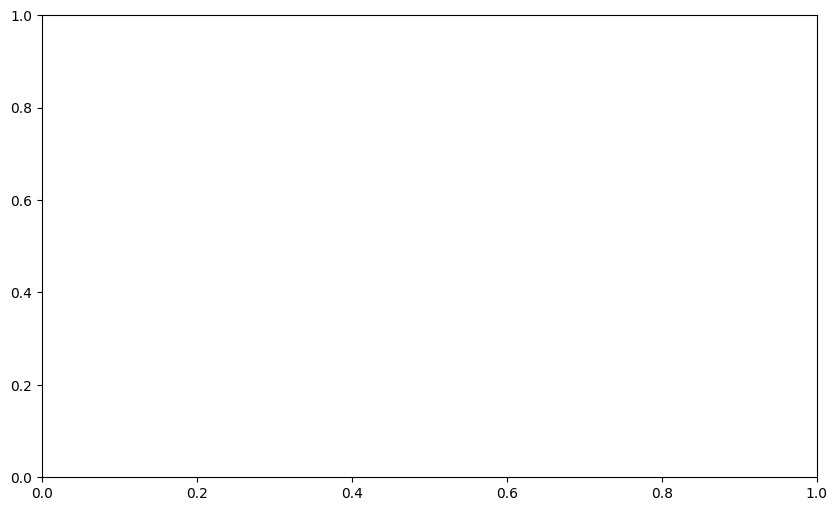

In [31]:

grouped_data = ressults_info_df.groupby(['frames_per_sec', 'Kernel_length'])

avg_accuracies = grouped_data['AUC'].mean().reset_index()
conf_intervals = grouped_data['AUC'].apply(lambda x: 1.96 * sem(x)).unstack()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for fps, group in avg_accuracies.groupby('frames_per_sec'):
    kernel_lengths = group['Kernel_length']
    accuracies = 1-group['AUC']
    yerr = conf_intervals.loc[fps]
    ax.errorbar(kernel_lengths, accuracies, yerr=yerr, label=f'Frames per sec: {fps}', fmt='o', capsize=5, capthick=2, markeredgecolor='black', linestyle='-')

ax.set_title('AUC 95% Confidence Intervals vs. Kernel Length (100 simulations each permutation )')
ax.set_xlabel('Kernel Length')
ax.set_ylabel('Average Accuracy')
ax.legend(title='Frames per sec')

plt.grid(True)
plt.show()


Using different dataset (here from UCR)

In [20]:
# Load training data
training_data = np.loadtxt("./UWaveGestureLibraryAll/UWaveGestureLibraryAll_TRAIN.txt")
Y_training, X_training = training_data[:, 0].astype(np.int32), training_data[:, 1:]

# Load test data
test_data = np.loadtxt("./UWaveGestureLibraryAll/UWaveGestureLibraryAll_TEST.txt")
Y_test, X_test = test_data[:, 0].astype(np.int32), test_data[:, 1:]


In [ ]:

kernels = generate_kernelss(X_training.shape[-1], 100000,np.array((7, 9, 11), dtype=np.int32))
X_training_transform = apply_kernels(X_training, kernels)
X_test_transform = apply_kernels(X_test, kernels)

In [442]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegressionCV

# Assuming 'classifier' is already trained
classifier = LogisticRegressionCV()
classifier.fit(X_training_transform, Y_training)
print(classifier.score(X_test_transform, Y_test))
predictions = classifier.predict(X_test_transform)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(Y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[429   0   0   0   0   6   0   2]
 [  1 451   0   0   0   0   0   0]
 [  2   0 432   0   9   9   1   1]
 [  3   0   2 421  20   4   0   0]
 [  5   0   6   1 418   2   0   1]
 [  4   0   4   4  26 409   0   2]
 [  2   0   1   0   0   0 444   0]
 [  0   0   2   5   0   0   0 453]]


In [443]:
print(classifier.score(X_test_transform, Y_test))

0.9651032942490229


In [444]:
warnings.filterwarnings('ignore')



pipeline = Pipeline([
    ('feature_selection', SelectFdr(chi2)),
    ('classifier', LogisticRegressionCV())
])


param_grid = {
    'feature_selection__alpha': [0.001, 0.02,0.01,0.05 ,0.1]  
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_training_transform, Y_training)


best_alpha = grid_search.best_params_['feature_selection__alpha']
print("Best alpha:", best_alpha)


best_pipeline = grid_search.best_estimator_
best_pipeline.fit(X_training_transform, Y_training)


accuracy = best_pipeline.score(X_test_transform, Y_test)
print("Accuracy:", accuracy)
predictions = best_pipeline.predict(X_test_transform)
conf_matrix = confusion_matrix(Y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)


Best alpha: 0.1
Accuracy: 0.954215522054718
Confusion Matrix:
[[422   0   0   2   0  13   0   0]
 [  1 448   0   0   0   1   1   1]
 [  1   2 429   0   3  16   2   1]
 [  3   0   1 408  19  15   0   4]
 [  3   2   7   1 417   2   0   1]
 [  5   0   4  12  28 399   0   1]
 [  2   0   1   2   0   2 439   1]
 [  0   0   1   3   0   0   0 456]]


In [416]:

data_reshaped_x_train = normalize_data(df2[0].reshape(df2[0].shape[0], -1))
data_reshaped_y_train = df2[1].reshape(df2[1].shape[0], -1)
data_reshaped_x_test = normalize_data(df2[2].reshape(df2[2].shape[0], -1))
data_reshaped_y_test = df2[3].reshape(df2[3].shape[0], -1)


kernels = generate_kernelss(data_reshaped_x_train.shape[-1], 10000,np.array((7, 9, 11), dtype=np.int32))
X_training_transform = apply_kernels(data_reshaped_x_train, kernels)
X_test_transform = apply_kernels(data_reshaped_x_test, kernels)
classifier = LogisticRegressionCV()
classifier.fit(data_reshaped_x_train, data_reshaped_y_train)
print(classifier.score(data_reshaped_x_test, data_reshaped_y_test))

0.5645161290322581


In [418]:
# Generate and apply kernels
from sklearn.feature_selection import SelectFdr, chi2
from sklearn.pipeline import Pipeline
data_reshaped_x_train = normalize_data(df2[0].reshape(df2[0].shape[0], -1))
data_reshaped_y_train = df2[1].reshape(df2[1].shape[0], -1)
data_reshaped_x_test = normalize_data(df2[2].reshape(df2[2].shape[0], -1))
data_reshaped_y_test = df2[3].reshape(df2[3].shape[0], -1)

kernels = generate_kernelss(data_reshaped_x_train.shape[-1], 100000,np.array((7, 9, 11), dtype=np.int32))
X_training_transform = apply_kernels(data_reshaped_x_train, kernels)
X_test_transform = apply_kernels(data_reshaped_x_test, kernels)

# Create a pipeline for feature selection and classification
pipeline = Pipeline([
    ('feature_selection', SelectFdr(chi2, alpha=0.1)),
    ('classifier', LogisticRegressionCV())
])

# Fit the pipeline
pipeline.fit(X_training_transform, data_reshaped_y_train)

# Evaluate the model on test data
accuracy = pipeline.score(X_test_transform, data_reshaped_y_test)
print("Accuracy:", accuracy)

ValueError: Found array with 0 feature(s) (shape=(280, 0)) while a minimum of 1 is required by LogisticRegressionCV.

In [303]:
data_reshaped_x_train = normalize_data(X_training.reshape(X_training.shape[0], -1))
data_reshaped_y_train = Y_training.reshape(Y_training.shape[0], -1)
data_reshaped_x_test = normalize_data(X_test.reshape(X_test.shape[0], -1))
data_reshaped_y_test = Y_test.reshape(Y_test.shape[0], -1)

In [304]:
X_training_transform.shape

(896, 100)

In [305]:
def drop_every_other_observation(dataset,n):
    dataframe = dataset.copy()  # Create a copy to avoid modifying the original dataset
    dataframe = dataframe[:, ::n]  # Slice the array to keep every other observation
    return dataframe


In [306]:

## Call this for dropping every 2,3,5
X_training_1=drop_every_other_observation(X_training,1)
X_training_2=drop_every_other_observation(X_training,2)
X_training_3=drop_every_other_observation(X_training,3)
X_training_6=drop_every_other_observation(X_training,6)

In [319]:
X_training_1.shape

(896, 945)

In [310]:
print(X_training_2.shape)
print(Y_training.shape)

(896, 473)
(896,)


In [292]:
vec_datas=[X_training_1,X_training_2,X_training_2,X_training_2]
vec_datas_size=[1,2,3,6]
# Define kernel sizes
kernels_sizes = [
    np.array((7, 9, 11), dtype=np.int32),  # default lengths
    np.array((15, 15, 15), dtype=np.int32),
    np.array((20, 20, 20), dtype=np.int32),
    np.array((30, 30, 30), dtype=np.int32),
    np.array((35, 35, 35), dtype=np.int32),
    np.array((40, 40, 40), dtype=np.int32),
    np.array((45, 45, 45), dtype=np.int32),
    np.array((60, 60, 60), dtype=np.int32),
    np.array((70, 70, 70), dtype=np.int32),
    np.array((80, 80, 80), dtype=np.int32),
    np.array((120, 120, 120), dtype=np.int32)
    # np.array((360, 360, 360), dtype=np.int32),
]


results_info=[]

trials=100
for h in range(trials):
    for j in range(len(vec_datas)):
        kernels = [generate_kernelss(X_training.shape[-1], 100,k) for k in kernels_sizes]
        for i in range(len(kernels_sizes)):
            X_training_transform = apply_kernels(vec_datas[j], kernels[i])
            classifier = LogisticRegressionCV()
            classifier.fit(X_training_transform, Y_training)
            X_test_transform = apply_kernels(X_test, kernels[i])
            predictions = classifier.predict(X_test_transform)
            probabilities=classifier.predict_proba(X_test_transform)
            results_dict = {
            "frames_per_sec":vec_datas_size[j],
            "Kernel_length":  kernels_sizes[i],
            "accuracy/score": classifier.score(X_test_transform, Y_test),
            "AUC":metrics.roc_auc_score(Y_test, probabilities,multi_class='ovr'),
            "n_kernels": 100,
            "final_classifier": "Logistic"}
            results_info.append(results_dict)
ressults_info_df = pd.DataFrame(results_info)


In [294]:
# Convert list of vectors to string representation
ressults_info_df["Kernel_length"]=ressults_info_df["Kernel_length"].apply(lambda x: ''.join(map(str, x)))

# Mapping dictionary
kernel_length_mapping = {
    '7911': "(7,9,11)",
    '151515': "15",
    '202020': "20",
    '303030': "30",
    '353535': "35",
    '404040': "40",
    '454545': "45",
    '606060': "60",
    '707070': "70",
    '707070': "70",
    '808080': "80",
    '120120120': "120",
}

# Replace kernel lengths in the DataFrame
ressults_info_df["Kernel_length"] = ressults_info_df["Kernel_length"].map(kernel_length_mapping)

# Convert 'Kernel_length' to categorical with custom ordering
ressults_info_df['Kernel_length'] = pd.Categorical(ressults_info_df['Kernel_length'], categories=list(kernel_length_mapping.values()), ordered=True)


In [326]:
ressults_info_df.to_pickle("results/results_100k_100i_logictic_auc_Uwave.pkl.pkl")

AttributeError: 'NoneType' object has no attribute 'to_pickle'

In [343]:
with open("results/results_100k_100i_logictic_auc_Uwave.pkl", "rb") as f:
    ressults_info_df = pickle.load(f)

In [340]:
# ressults_info_df.drop(ressults_info_df[ressults_info_df["frames_per_sec"] == 1].index, inplace=True)


In [490]:
ressults_info_df.drop(ressults_info_df[ressults_info_df["frames_per_sec"] == 1].index, inplace=True)


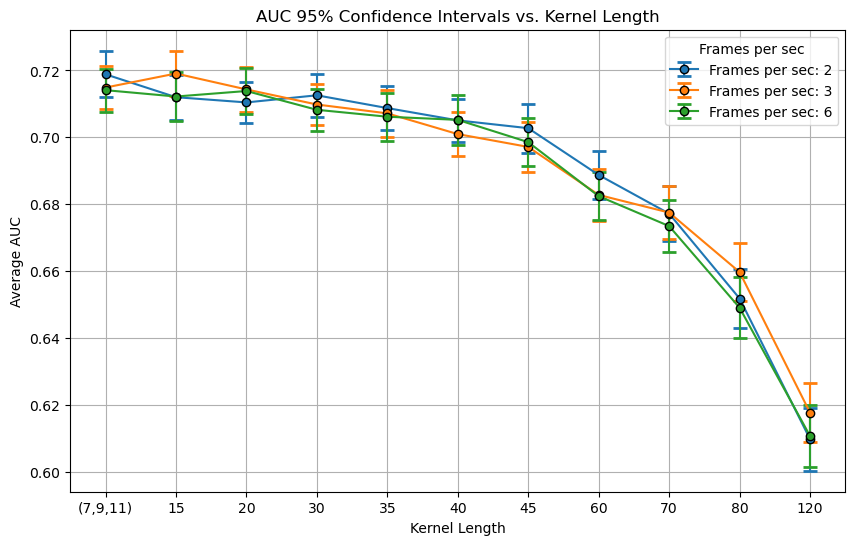

In [491]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from scipy.stats import sem

# Group the data
grouped_data = ressults_info_df.groupby(['frames_per_sec', 'Kernel_length'])

# Calculate average accuracies and confidence intervals
avg_accuracies = grouped_data['AUC'].mean().reset_index()
conf_intervals = grouped_data['AUC'].apply(lambda x: 1.96 * sem(x)).unstack()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for fps, group in avg_accuracies.groupby('frames_per_sec'):
    kernel_lengths = group['Kernel_length']
    accuracies = group['AUC']
    yerr = conf_intervals.loc[fps]
    ax.errorbar(kernel_lengths, accuracies, yerr=yerr, label=f'Frames per sec: {fps}', fmt='o', capsize=5, capthick=2, markeredgecolor='black', linestyle='-')

ax.set_title('AUC 95% Confidence Intervals vs. Kernel Length')
ax.set_xlabel('Kernel Length')
ax.set_ylabel('Average AUC')
ax.legend(title='Frames per sec')

plt.grid(True)
plt.show()


In [352]:

# Load training data
training_data = np.loadtxt("/Users/viniciusono/ML-research/kernel_size_exploration/FaceAll/FaceAll_TRAIN.txt")
Y_training, X_training = training_data[:, 0].astype(np.int32), training_data[:, 1:]

# Load test data
test_data = np.loadtxt("/Users/viniciusono/ML-research/kernel_size_exploration/FaceAll/FaceAll_TEST.txt")
Y_test, X_test = test_data[:, 0].astype(np.int32), test_data[:, 1:]


In [355]:
X_training

array([[-0.24759242, -0.33250262, -0.63210547, ...,  0.02770968,
         0.09078972, -0.32731244],
       [-0.64157738, -0.93941995, -1.3001737 , ..., -0.38880448,
        -0.58183734, -0.24863042],
       [-1.672048  , -1.8815147 , -2.0909815 , ..., -0.32589473,
        -0.32589473, -0.32589473],
       ...,
       [-0.58009978, -0.91537015, -1.2035215 , ..., -1.2978307 ,
        -1.4583973 , -0.87365684],
       [-0.49667316, -0.91444455, -1.2553569 , ..., -0.57532295,
        -1.0775952 , -1.5953599 ],
       [-1.374355  , -1.2174566 , -0.65528799, ...,  1.8814666 ,
         2.6237418 ,  0.83324334]])

In [356]:

## Call this for dropping every 2,3,5
X_training_1=drop_every_other_observation(X_training,1)
X_training_2=drop_every_other_observation(X_training,2)
X_training_3=drop_every_other_observation(X_training,3)
X_training_6=drop_every_other_observation(X_training,6)

vec_datas=[X_training_1,X_training_2,X_training_2,X_training_2]
vec_datas_size=[1,2,3,6]
# Define kernel sizes
kernels_sizes = [
    np.array((7, 9, 11), dtype=np.int32),  # default lengths
    np.array((15, 15, 15), dtype=np.int32),
    np.array((20, 20, 20), dtype=np.int32),
    np.array((30, 30, 30), dtype=np.int32),
    np.array((35, 35, 35), dtype=np.int32),
    np.array((40, 40, 40), dtype=np.int32),
    np.array((45, 45, 45), dtype=np.int32),
    np.array((60, 60, 60), dtype=np.int32),
    np.array((70, 70, 70), dtype=np.int32),
    np.array((80, 80, 80), dtype=np.int32),
    np.array((120, 120, 120), dtype=np.int32)
    # np.array((360, 360, 360), dtype=np.int32),
]


results_info=[]

trials=100
for h in range(trials):
    for j in range(len(vec_datas)):
        kernels = [generate_kernelss(X_training.shape[-1], 100,k) for k in kernels_sizes]
        for i in range(len(kernels_sizes)):
            X_training_transform = apply_kernels(vec_datas[j], kernels[i])
            classifier = LogisticRegressionCV()
            classifier.fit(X_training_transform, Y_training)
            X_test_transform = apply_kernels(X_test, kernels[i])
            predictions = classifier.predict(X_test_transform)
            probabilities=classifier.predict_proba(X_test_transform)
            results_dict = {
            "frames_per_sec":vec_datas_size[j],
            "Kernel_length":  kernels_sizes[i],
            "accuracy/score": classifier.score(X_test_transform, Y_test),
            "AUC":metrics.roc_auc_score(Y_test, probabilities,multi_class='ovr'),
            "n_kernels": 100,
            "final_classifier": "Logistic"}
            results_info.append(results_dict)
ressults_info_df = pd.DataFrame(results_info)


SystemError: _PyEval_EvalFrameDefault returned a result with an error set

In [ ]:
# Convert list of vectors to string representation
ressults_info_df["Kernel_length"]=ressults_info_df["Kernel_length"].apply(lambda x: ''.join(map(str, x)))

# Mapping dictionary
kernel_length_mapping = {
    '7911': "(7,9,11)",
    '151515': "15",
    '202020': "20",
    '303030': "30",
    '353535': "35",
    '404040': "40",
    '454545': "45",
    '606060': "60",
    '707070': "70",
    '707070': "70",
    '808080': "80",
    '120120120': "120",
}

# Replace kernel lengths in the DataFrame
ressults_info_df["Kernel_length"] = ressults_info_df["Kernel_length"].map(kernel_length_mapping)

# Convert 'Kernel_length' to categorical with custom ordering
ressults_info_df['Kernel_length'] = pd.Categorical(ressults_info_df['Kernel_length'], categories=list(kernel_length_mapping.values()), ordered=True)


In [ ]:
ressults_info_df.to_pickle("results/results_100k_100i_logictic_auc_Face.pkl.pkl")